# Transient metric

This notebook demonstrates the transient metric.  For this metric, one can set the light curve shape and detection threshold (e.g., one detection, demand a detection on the rise, demand multiple filters, etc).  The metric then computes what fraction of sources would meet the detection criteria if the object was continually exploding throughout the survey.  

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

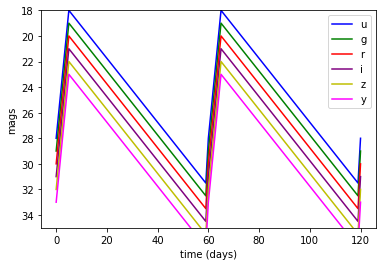

In [2]:
# Let's look at how the transient metric makes light curves
peaks = {'uPeak': 18, 'gPeak': 19, 'rPeak': 20,
         'iPeak': 21, 'zPeak': 22,'yPeak': 23}
colors = ['b', 'g', 'r', 'purple', 'y', 'magenta', 'k']
filterNames = ['u', 'g', 'r', 'i', 'z', 'y']

transDuration = 60. # Days
transMetric = metrics.TransientMetric(
    riseSlope=-2., declineSlope=0.25,
    transDuration=transDuration, peakTime=5., **peaks)


times = np.arange(0., 121, 1) 
for filterName, color in zip(filterNames, colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

So the transient metric basically takes a simple lightcurve, repeats it continually over the entire survey length, and then checks to see what fraction of the lightcurves meet some specified criteria.

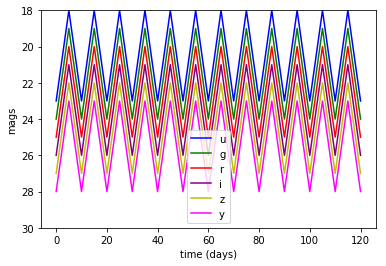

In [3]:
# Modify the slopes and duration a bit
transDuration = 10.
transMetric = metrics.TransientMetric(
    riseSlope=-1., declineSlope=1, 
    transDuration=transDuration, peakTime=5., **peaks)


times = np.arange(0., 121, 1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration, filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([30,18])
plt.legend()

By default, the transient metric let's you make simple saw-tooth light curves.  If you want to use a more complicated light curve, one can simply sub-class the transient metric and replace the lightCurve method with a function of your own. 

In [4]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric()]
# Configure some metrics
metricList = []
# What fraction of 60-day, r=20 mag flat transients are detected at least once?
metric = metrics.TransientMetric(
    riseSlope=0., declineSlope=0., transDuration=60., 
    peakTime=5., rPeak=20., metricName='Alert')
metricList.append(metric)
# Now make the light curve shape a little more realistic. 
metric = metrics.TransientMetric(
    riseSlope=-2., declineSlope=0.25, transDuration=60., 
    peakTime=5., rPeak=20., metricName='Alert, shaped LC')
metricList.append(metric)
#  Demand 2 points before tmax before counting the LC as detected
metric = metrics.TransientMetric(
    riseSlope=-2., declineSlope=0.25, transDuration=60., 
    peakTime=5., rPeak=20., nPrePeak=2, metricName='Detected on rise')
metricList.append(metric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
# Set the database and query
runName = 'baseline2018a'
sqlconstraint = 'filter = "r"'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint, 
        runName=runName, summaryMetrics=summaryMetrics)

In [6]:
opsdb = db.OpsimDatabase(runName + '.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

In [7]:
bgroup = metricBundles.MetricBundleGroup(
    bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['observationStartMJD', 'filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 515172 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter = "r"" constraint now.
monopole: 0.469276  dipole: lon: -81.9234, lat: 5.61379, amp: 0.0294283
monopole: 0.26446  dipole: lon: -76.335, lat: -46.2103, amp: 0.0329731
monopole: 0.0348827  dipole: lon: -177.557, lat: -33.0874, amp: 0.01716
Plotting complete.


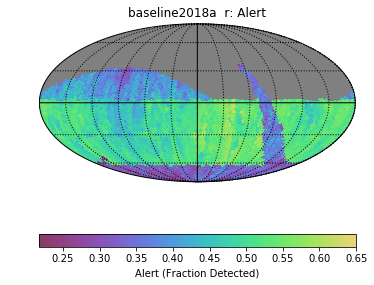

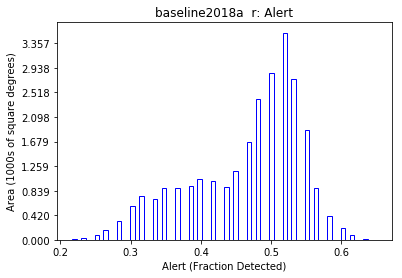

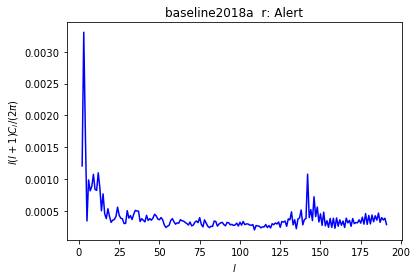

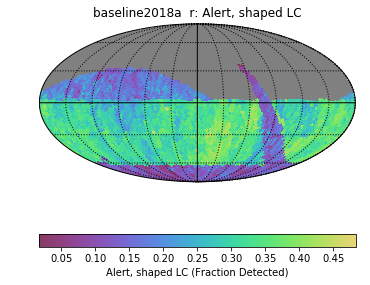

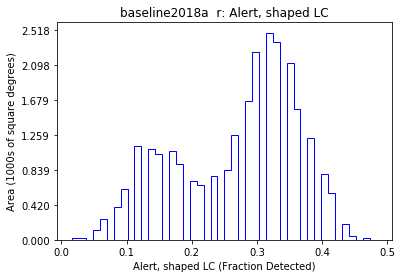

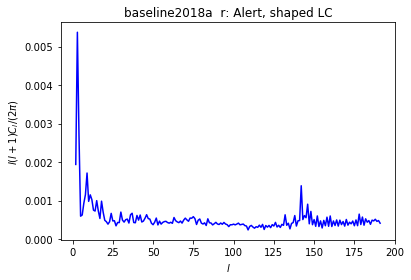

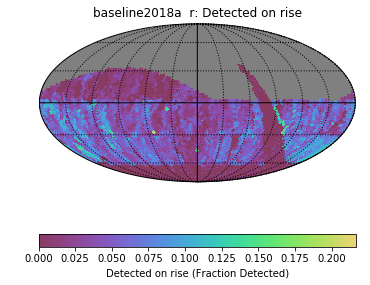

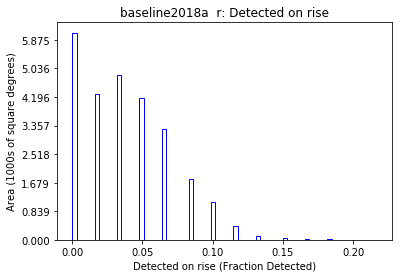

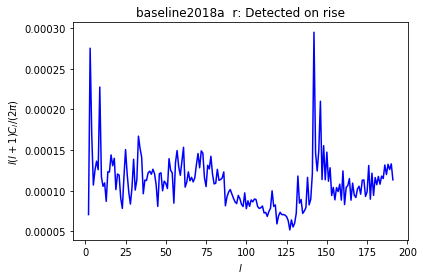

In [8]:
bgroup.plotAll(closefigs=False)

In [9]:
# Compute and print summary metrics
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print(bDict[key].metric.name, bDict[key].summaryValues)

Alert {'Median': 0.48333333333333334}
Alert, shaped LC {'Median': 0.29999999999999999}
Detected on rise {'Median': 0.033333333333333333}


Querying database SummaryAllProps with no constraint for columns ['observationStartMJD', 'filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth'].
Found 2372700 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
monopole: 0.625213  dipole: lon: -67.1454, lat: -25.4059, amp: 0.0550747
monopole: 0.444497  dipole: lon: -72.2955, lat: -27.7155, amp: 0.0493888
monopole: 0.118322  dipole: lon: 174.676, lat: -61.7927, amp: 0.0229575
Plotting complete.
Alert {'Median': 0.6333333333333333}
Alert, shaped LC {'Median': 0.46666666666666667}
Detected on rise {'Median': 0.13333333333333333}


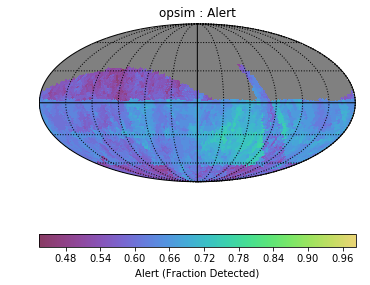

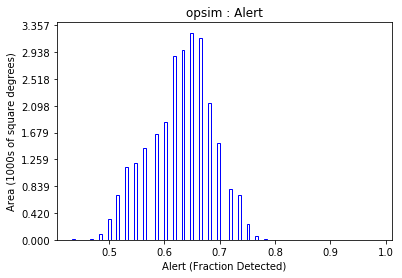

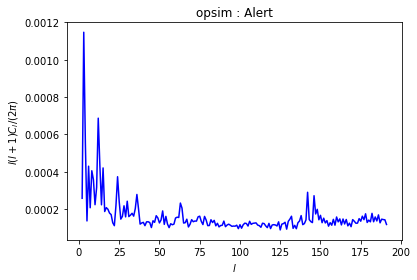

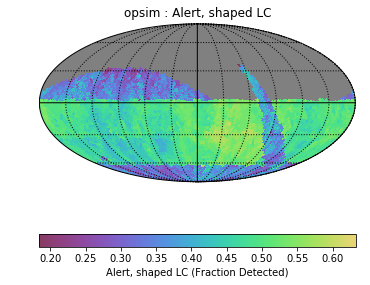

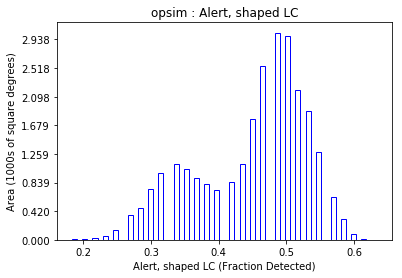

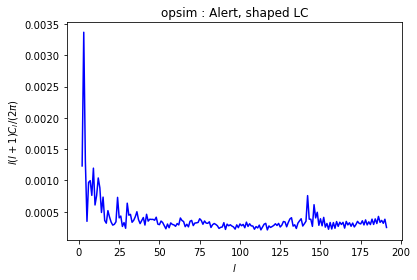

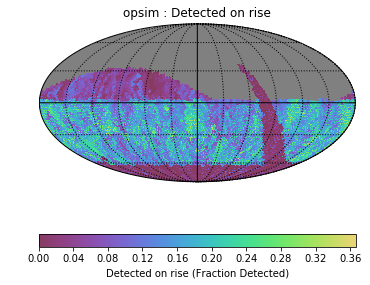

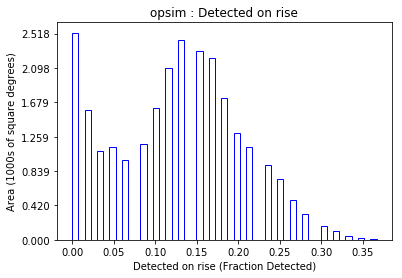

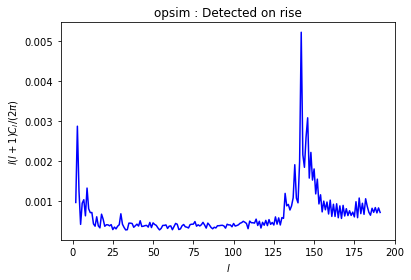

In [10]:
# Update to use all the observations, not just the r-band
bDict={}
sqlconstraint = ''
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint, summaryMetrics=summaryMetrics)

bgroup = metricBundles.MetricBundleGroup(
    bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print(bDict[key].metric.name, bDict[key].summaryValues)

In [11]:
bDict[0].metricValues

masked_array(data = [-- -- -- ..., 0.6166666666666667 0.6166666666666667 0.7166666666666667],
             mask = [ True  True  True ..., False False False],
       fill_value = -1.6375e+30)